<a href="https://colab.research.google.com/github/max-dev-eng/ResearchPaperRepository/blob/main/Fig_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================
# FTCS (explicit) 2D cooling of a 0.5m x 0.5m carbon-ceramic plate
# with 25 CIRCULAR holes (5x5 incl. centre), diameter = 1 cm
# Robin (convective) BC on:
#   - outer square edges
#   - hole boundaries (solid/void interface treated as Robin via ghost neighbor)
#
# Plotting-only improvement:
#   - Plot on a fine grid (bilinear-interpolated temperature)
#   - Recompute hole mask on fine grid for visually smooth circular holes
#   - Simulation grid/physics unchanged
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Colab download helpers
try:
    from google.colab import files
    from IPython.display import FileLink, display
    IN_COLAB = True
except Exception:
    IN_COLAB = False

# -----------------------------
# Constants (carbon-ceramic)
# -----------------------------
rho = 1780
cp = 2218
k = 86.3                # W/(m K)
h = 100.0               # W/(m^2 K)
alpha = k / (rho * cp)          # m^2/s
T_init = 1273.15        # K
T_inf  = 296.15         # K

# -----------------------------
# Domain/grid (UNCHANGED)
# -----------------------------
Lx = Ly = 0.5
Nx = Ny = 301
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)
assert abs(dx - dy) < 1e-15, "This script assumes dx == dy."

x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y, indexing="ij")

# -----------------------------
# 25 circular holes (UNCHANGED)
# -----------------------------
r_hole = 0.005  # m
centers_1d = np.linspace(0.05, 0.45, 5)  # includes center 0.25
centers = [(cx, cy) for cx in centers_1d for cy in centers_1d]

hole = np.zeros((Nx, Ny), dtype=bool)
for (cx, cy) in centers:
    hole |= (X - cx)**2 + (Y - cy)**2 <= r_hole**2

solid = ~hole

# -----------------------------
# Time settings (FTCS stability) (UNCHANGED)
# -----------------------------
t_end = 3000.0
dt_max = 0.25 * dx*dx / alpha
dt = 0.80 * dt_max  # safety factor

Nt = int(np.ceil(t_end / dt))
dt = t_end / Nt     # adjust so final time hits exactly
r = alpha * dt / (dx*dx)

# Robin parameter (UNCHANGED)
beta = (h * dx / k)

# snapshots every 30 s INCLUDING 3000 (UNCHANGED)
snap_times = np.arange(0.0, t_end + 1e-9, 30.0)
snap_steps = {int(round(t/dt)): t for t in snap_times}

# -----------------------------
# Fixed colour scale (UNCHANGED)
# -----------------------------
vmin_fixed = T_inf
vmax_fixed = T_init
levels = np.linspace(vmin_fixed, vmax_fixed, 200)
cmap = plt.cm.plasma.copy()
cmap.set_bad(color="white")

# -----------------------------
# Initial condition (UNCHANGED)
# -----------------------------
T = np.full((Nx, Ny), T_init, dtype=np.float64)
T[hole] = T_inf

# -----------------------------
# Helper: Robin ghost neighbor value (UNCHANGED)
# -----------------------------
def robin_ghost(Tcell):
    return Tcell - beta * (Tcell - T_inf)

# ============================================================
# PLOTTING-ONLY: fine grid + bilinear interpolation + exact hole mask
# ============================================================
PLOT_N = 900  # higher => smoother circles in PDF (plotting only)
xf = np.linspace(0.0, Lx, PLOT_N)
yf = np.linspace(0.0, Ly, PLOT_N)
Xf, Yf = np.meshgrid(xf, yf, indexing="ij")

hole_f = np.zeros((PLOT_N, PLOT_N), dtype=bool)
for (cx, cy) in centers:
    hole_f |= (Xf - cx)**2 + (Yf - cy)**2 <= r_hole**2
solid_f = ~hole_f

def bilinear_interp_to_fine(Tcoarse, xf, yf, x0, y0, dx, dy):
    # Map fine coords to coarse fractional indices
    ix = (xf - x0) / dx
    iy = (yf - y0) / dy

    ix = np.clip(ix, 0.0, Tcoarse.shape[0] - 1 - 1e-12)
    iy = np.clip(iy, 0.0, Tcoarse.shape[1] - 1 - 1e-12)

    i0 = np.floor(ix).astype(np.int64)
    j0 = np.floor(iy).astype(np.int64)
    i1 = i0 + 1
    j1 = j0 + 1

    tx = (ix - i0).astype(np.float64)
    ty = (iy - j0).astype(np.float64)

    # Broadcast to 2D
    i0_2d = i0[:, None]
    i1_2d = i1[:, None]
    j0_2d = j0[None, :]
    j1_2d = j1[None, :]

    tx_2d = tx[:, None]
    ty_2d = ty[None, :]

    T00 = Tcoarse[i0_2d, j0_2d]
    T10 = Tcoarse[i1_2d, j0_2d]
    T01 = Tcoarse[i0_2d, j1_2d]
    T11 = Tcoarse[i1_2d, j1_2d]

    return ((1 - tx_2d) * (1 - ty_2d) * T00 +
            (tx_2d)     * (1 - ty_2d) * T10 +
            (1 - tx_2d) * (ty_2d)     * T01 +
            (tx_2d)     * (ty_2d)     * T11)

# -----------------------------
# Output
# -----------------------------
out_pdf = "FTCS_25holes_robin_3000s.pdf"

with PdfPages(out_pdf) as pdf:
    for n in range(Nt + 1):

        # ---- Save snapshot BEFORE stepping ----
        if n in snap_steps:
            t = snap_steps[n]

            # Plotting-only: interpolate to fine grid
            Tf = bilinear_interp_to_fine(T, xf, yf, x[0], y[0], dx, dy)
            Tf_plot = np.where(solid_f, Tf, np.nan)

            fig = plt.figure(figsize=(6.8, 5.8), dpi=220)
            ax = plt.gca()

            cf = ax.contourf(
                Xf, Yf, Tf_plot,
                levels=levels, vmin=vmin_fixed, vmax=vmax_fixed, cmap=cmap
            )

            ax.set_aspect("equal")
            ax.set_xlim(0, Lx); ax.set_ylim(0, Ly)
            ax.set_xlabel("x (m)")
            ax.set_ylabel("y (m)")
            ax.set_title(f"Temperature at t = {int(round(t))} s (FTCS, Robin edges + hole walls)")
            ax.grid(True, linestyle="--", alpha=0.30)

            cb = plt.colorbar(cf)
            cb.set_label("Temperature (K)")
            cb.set_ticks(np.linspace(vmin_fixed, vmax_fixed, 10))

            pdf.savefig(fig)
            plt.close(fig)

        if n == Nt:
            break

        # ---- FTCS step with Robin edges + Robin hole walls (UNCHANGED) ----
        Tn = T.copy()

        # Neighbor arrays
        Txp = Tn.copy(); Txm = Tn.copy(); Typ = Tn.copy(); Tym = Tn.copy()
        Txp[:-1, :] = Tn[1:, :]
        Txm[1:,  :] = Tn[:-1, :]
        Typ[:, :-1] = Tn[:, 1:]
        Tym[:, 1: ] = Tn[:, :-1]

        # Outer edges: Robin ghosts
        Txm[0, :]   = robin_ghost(Tn[0, :])
        Txp[-1, :]  = robin_ghost(Tn[-1, :])
        Tym[:, 0]   = robin_ghost(Tn[:, 0])
        Typ[:, -1]  = robin_ghost(Tn[:, -1])

        # Hole walls: if neighbor is void, replace that neighbor by Robin ghost
        solid_xp = np.zeros_like(solid); solid_xp[:-1, :] = solid[1:, :]
        solid_xm = np.zeros_like(solid); solid_xm[1:,  :] = solid[:-1, :]
        solid_yp = np.zeros_like(solid); solid_yp[:, :-1] = solid[:, 1:]
        solid_ym = np.zeros_like(solid); solid_ym[:, 1: ] = solid[:, :-1]

        need_xp = solid & (~solid_xp)
        need_xm = solid & (~solid_xm)
        need_yp = solid & (~solid_yp)
        need_ym = solid & (~solid_ym)

        Txp[need_xp] = robin_ghost(Tn[need_xp])
        Txm[need_xm] = robin_ghost(Tn[need_xm])
        Typ[need_yp] = robin_ghost(Tn[need_yp])
        Tym[need_ym] = robin_ghost(Tn[need_ym])

        lap = (Txp + Txm + Typ + Tym - 4.0*Tn) / (dx*dx)

        # Update only solid; keep holes at ambient
        T = Tn.copy()
        T[solid] = Tn[solid] + alpha * dt * lap[solid]
        T[hole] = T_inf

print("Saved:", out_pdf)
print(f"Nx=Ny={Nx}, dx={dx:.6e} m, dt={dt:.6f} s, Nt={Nt}, r={r:.6f} (must be <= 0.25)")
print("Holes: 25 (5x5 evenly distributed), diameter = 0.01 m")

if IN_COLAB:
    display(FileLink(out_pdf))
    files.download(out_pdf)

Saved: FTCS_25holes_robin_3000s.pdf
Nx=Ny=301, dx=1.666667e-03 m, dt=0.025415 s, Nt=118039, r=0.199999 (must be <= 0.25)
Holes: 25 (5x5 evenly distributed), diameter = 0.01 m


/content/FTCS_25holes_robin_3000s.pdf

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Stability check: r=0.199999 (must be <= 0.25) | dt=0.025415 s | Nt=62954
t≈250.01s: mean_solid=1204.601 K | running_avg=1238.261 K
t≈500.00s: mean_solid=1142.006 K | running_avg=1205.573 K


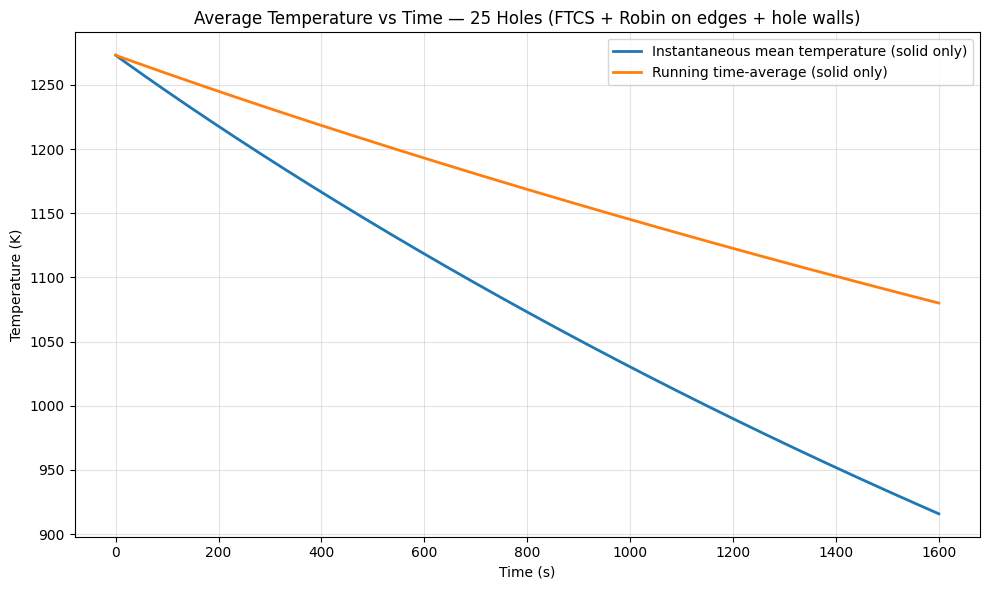

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# FTCS (explicit) 2D cooling of a 0.5m x 0.5m carbon-ceramic plate
# 25 circular holes (5x5), diameter = 1 cm
# Robin (convective) BC on:
#   - outer edges
#   - hole walls (solid/void interface via Robin ghost-neighbour)
#
# Outputs:
#   - Graph: instantaneous mean T (solid only) + running time-average
#   - Numeric evidence at t≈250 s and t≈500 s (solid-only mean)
# ============================================================

# -----------------------------
# Constants (carbon-ceramic)
# -----------------------------
rho = 1780
cp = 2218
k = 86.3                # W/(m K)
h = 100.0               # W/(m^2 K)
alpha = k / (rho * cp)          # m^2/s

T_init = 1273.15        # K
T_inf  = 296.15         # K

# -----------------------------
# Domain / grid
# -----------------------------
Lx = Ly = 0.5
Nx = Ny = 301
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)
assert abs(dx - dy) < 1e-15, "Assumes dx == dy."

x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y, indexing="ij")

# -----------------------------
# 25 holes (5x5), diameter 1 cm
# -----------------------------
r_hole = 0.005  # m
centers_1d = np.linspace(0.05, 0.45, 5)
centers = [(cx, cy) for cx in centers_1d for cy in centers_1d]

hole = np.zeros((Nx, Ny), dtype=bool)
for (cx, cy) in centers:
    hole |= (X - cx)**2 + (Y - cy)**2 <= r_hole**2

solid = ~hole

# -----------------------------
# Time settings (FTCS stability)
# 2D FTCS with dx=dy: r = alpha*dt/dx^2 <= 0.25
# -----------------------------
t_end = 1600.0
dt_max = 0.25 * dx*dx / alpha
dt = 0.80 * dt_max

Nt = int(np.ceil(t_end / dt))
dt = t_end / Nt
r = alpha * dt / (dx*dx)

# Robin parameter beta = h*dx/k used in ghost neighbour
beta = (h * dx / k)

def robin_ghost(Tcell):
    # ghost = Tcell - beta*(Tcell - T_inf)
    return Tcell - beta * (Tcell - T_inf)

# -----------------------------
# Precompute interface masks (static geometry)
# -----------------------------
solid_xp = np.zeros_like(solid); solid_xp[:-1, :] = solid[1:, :]
solid_xm = np.zeros_like(solid); solid_xm[1:,  :] = solid[:-1, :]
solid_yp = np.zeros_like(solid); solid_yp[:, :-1] = solid[:, 1:]
solid_ym = np.zeros_like(solid); solid_ym[:, 1: ] = solid[:, :-1]

need_xp = solid & (~solid_xp)   # +x neighbour is void OR outside solid
need_xm = solid & (~solid_xm)
need_yp = solid & (~solid_yp)
need_ym = solid & (~solid_ym)

# -----------------------------
# Initial condition
# -----------------------------
T = np.full((Nx, Ny), T_init, dtype=np.float64)
T[hole] = T_inf

# -----------------------------
# Storage for graph (solid-only)
# -----------------------------
times = np.arange(Nt+1, dtype=float) * dt
mean_solid = np.empty(Nt+1, dtype=float)
runavg_solid = np.empty(Nt+1, dtype=float)

mean_solid[0] = T[solid].mean()
runavg_solid[0] = mean_solid[0]

# Running average via trapezoidal integral
area = 0.0

# -----------------------------
# FTCS time stepping
# -----------------------------
for n in range(1, Nt+1):
    Tn = T.copy()

    # Neighbour arrays
    Txp = Tn.copy(); Txm = Tn.copy(); Typ = Tn.copy(); Tym = Tn.copy()
    Txp[:-1, :] = Tn[1:, :]
    Txm[1:,  :] = Tn[:-1, :]
    Typ[:, :-1] = Tn[:, 1:]
    Tym[:, 1: ] = Tn[:, :-1]

    # Outer edges: Robin ghosts
    Txm[0, :]   = robin_ghost(Tn[0, :])
    Txp[-1, :]  = robin_ghost(Tn[-1, :])
    Tym[:, 0]   = robin_ghost(Tn[:, 0])
    Typ[:, -1]  = robin_ghost(Tn[:, -1])

    # Hole walls (solid–void interfaces): Robin ghost neighbour
    Txp[need_xp] = robin_ghost(Tn[need_xp])
    Txm[need_xm] = robin_ghost(Tn[need_xm])
    Typ[need_yp] = robin_ghost(Tn[need_yp])
    Tym[need_ym] = robin_ghost(Tn[need_ym])

    lap = (Txp + Txm + Typ + Tym - 4.0*Tn) / (dx*dx)

    # Update only solid; keep holes at ambient
    T = Tn.copy()
    T[solid] = Tn[solid] + alpha * dt * lap[solid]
    T[hole]  = T_inf

    mean_solid[n] = T[solid].mean()

    # trapezoid integral update: area += 0.5*(m_n + m_{n-1})*dt
    area += 0.5 * (mean_solid[n] + mean_solid[n-1]) * dt
    runavg_solid[n] = area / times[n] if times[n] > 0 else mean_solid[n]

print(f"Stability check: r={r:.6f} (must be <= 0.25) | dt={dt:.6f} s | Nt={Nt}")

def sample_at(t_query):
    idx = int(np.argmin(np.abs(times - t_query)))
    return times[idx], mean_solid[idx], runavg_solid[idx]

for tq in [250.0, 500.0]:
    tt, ms, ra = sample_at(tq)
    print(f"t≈{tt:.2f}s: mean_solid={ms:.3f} K | running_avg={ra:.3f} K")

plt.figure(figsize=(10, 6))
plt.plot(times, mean_solid, linewidth=2, label="Instantaneous mean temperature (solid only)")
plt.plot(times, runavg_solid, linewidth=2, label="Running time-average (solid only)")
plt.title("Average Temperature vs Time — 25 Holes (FTCS + Robin on edges + hole walls)")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.grid(True, alpha=0.35)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 2D transient heat diffusion on a 0.5m x 0.5m carbon-ceramic plate
# FTCS time stepping + Robin (convective) BCs on all outer edges
# Snapshots every 30 s from t=0 to t=1590, total sim time 1600 s
# Consistent color scale across all frames
#
# CHANGE HERE (PLOTTING ONLY):
# - Use fewer contour levels (prevents "choppy/speckled" artifacts in PDFs at t=0)
# - Rasterize the contour sets in a version-safe way (no .collections crash)
# - Slightly higher figure DPI for cleaner rasterization
#
# Simulation + physics are unchanged.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Colab download helpers
try:
    from google.colab import files
    from IPython.display import FileLink, display
    IN_COLAB = True
except Exception:
    IN_COLAB = False

# -----------------------------
# Given constants (carbon-ceramic)
# -----------------------------
rho = 1780
cp = 2218
k = 86.3                # W/(m K)
h = 100.0               # W/(m^2 K)
alpha = k / (rho * cp)          # m^2/s

T_init = 1273.15        # K  (1000 °C)
T_inf  = 296.15         # K  (23 °C)

# -----------------------------
# Domain / grid
# -----------------------------
Lx = Ly = 0.5
Nx = Ny = 81
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y, indexing="ij")

# -----------------------------
# FTCS stability (2D): r <= 0.25 (dx=dy)
# -----------------------------
dt_max = 0.25 * min(dx, dy)**2 / alpha
dt = 0.80 * dt_max

t_end = 1600.0
Nt = int(np.ceil(t_end/dt))
dt = t_end/Nt

# -----------------------------
# Snapshot schedule
# -----------------------------
snap_times = np.arange(0.0, 1600.0, 30.0)  # 0,30,...,1590
snap_steps = {int(round(t/dt)): t for t in snap_times}

# -----------------------------
# Robin boundary via ghost cell
# -----------------------------
def robin_ghost(Tcell, d):
    return Tcell - (h*d/k)*(Tcell - T_inf)

# -----------------------------
# Fixed, consistent color scale
# -----------------------------
vmin_fixed = T_inf
vmax_fixed = T_init

# PLOTTING-ONLY: fewer levels to avoid PDF speckle/cracks at uniform fields
N_LEVELS = 90
levels = np.linspace(vmin_fixed, vmax_fixed, N_LEVELS)
cmap = plt.cm.plasma

# -----------------------------
# Initial condition
# -----------------------------
T = np.full((Nx, Ny), T_init, dtype=float)

# ==========================================================
# 16 evenly distributed CIRCULAR perforations
# + Convective (Robin) BCs on perforation boundaries
# + Convective (Robin) BCs on outer plate edges (already present)
# ==========================================================
holes_per_side = 4
hole_diameter = 0.01  # m
hole_radius = 0.5 * hole_diameter

xs = np.linspace(Lx/(holes_per_side+1), Lx*holes_per_side/(holes_per_side+1), holes_per_side)
ys = np.linspace(Ly/(holes_per_side+1), Ly*holes_per_side/(holes_per_side+1), holes_per_side)
hole_centers = [(xc, yc) for xc in xs for yc in ys]

solid = np.ones((Nx, Ny), dtype=bool)
for (xc, yc) in hole_centers:
    solid &= (((X - xc)**2 + (Y - yc)**2) > hole_radius**2)

T[~solid] = T_inf

# -----------------------------
# PLOTTING-ONLY: fine plotting grid + exact circle mask
# -----------------------------
PLOT_N = 600
xf = np.linspace(0.0, Lx, PLOT_N)
yf = np.linspace(0.0, Ly, PLOT_N)
Xf, Yf = np.meshgrid(xf, yf, indexing="ij")

solid_f = np.ones((PLOT_N, PLOT_N), dtype=bool)
for (xc, yc) in hole_centers:
    solid_f &= (((Xf - xc)**2 + (Yf - yc)**2) > hole_radius**2)

def bilinear_interp_to_fine(Tcoarse, xf, yf):
    ix = (xf - x[0]) / dx
    iy = (yf - y[0]) / dy
    ix = np.clip(ix, 0.0, Nx - 1 - 1e-12)
    iy = np.clip(iy, 0.0, Ny - 1 - 1e-12)

    i0 = np.floor(ix).astype(np.int64)
    j0 = np.floor(iy).astype(np.int64)
    i1 = i0 + 1
    j1 = j0 + 1

    tx = (ix - i0).astype(np.float64)
    ty = (iy - j0).astype(np.float64)

    i0_2d = i0[:, None]
    i1_2d = i1[:, None]
    j0_2d = j0[None, :]
    j1_2d = j1[None, :]

    tx_2d = tx[:, None]
    ty_2d = ty[None, :]

    T00 = Tcoarse[i0_2d, j0_2d]
    T10 = Tcoarse[i1_2d, j0_2d]
    T01 = Tcoarse[i0_2d, j1_2d]
    T11 = Tcoarse[i1_2d, j1_2d]

    return (1 - tx_2d) * (1 - ty_2d) * T00 + \
           (tx_2d)     * (1 - ty_2d) * T10 + \
           (1 - tx_2d) * (ty_2d)     * T01 + \
           (tx_2d)     * (ty_2d)     * T11

# -----------------------------
# Output
# -----------------------------
out_pdf = "carbon_ceramic_plate_robin_1000s.pdf"
FIG_DPI = 220  # plotting-only

with PdfPages(out_pdf) as pdf:
    for n in range(Nt + 1):

        # ---- Save snapshot BEFORE stepping ----
        if n in snap_steps:
            t = snap_steps[n]
            fig = plt.figure(figsize=(6, 5), dpi=FIG_DPI)
            ax = plt.gca()

            Tf = bilinear_interp_to_fine(T, xf, yf)
            Tf_plot = np.where(solid_f, Tf, np.nan)

            # ----------------------------
            # PLOTTING-ONLY FIX (t = 0):
            # Use imshow (raster) for the uniform initial field to avoid PDF speckle.
            # ----------------------------
            if int(round(t)) == 0:
                Tf_masked = np.ma.masked_invalid(Tf_plot)
                im = ax.imshow(
                    Tf_masked.T,
                    extent=[0.0, Lx, 0.0, Ly],
                    origin="lower",
                    cmap=cmap,
                    vmin=vmin_fixed,
                    vmax=vmax_fixed,
                    interpolation="bilinear"
                )
                mappable = im
            else:
                cf = ax.contourf(
                    Xf, Yf, Tf_plot,
                    levels=levels, vmin=vmin_fixed, vmax=vmax_fixed, cmap=cmap
                )
                # FIX: version-safe rasterization (no .collections dependency)
                if hasattr(cf, "set_rasterized"):
                    cf.set_rasterized(True)

                cs = ax.contour(Xf, Yf, Tf_plot, levels=60, colors="w", alpha=0.18, linewidths=0.6)
                if hasattr(cs, "set_rasterized"):
                    cs.set_rasterized(True)

                mappable = cf

            for (xc, yc) in hole_centers:
                ax.add_patch(plt.Circle((xc, yc), hole_radius, fill=False,
                                        color="white", linewidth=1.0, alpha=0.7))

            ax.set_aspect("equal")
            ax.set_xlim(0, Lx); ax.set_ylim(0, Ly)
            ax.set_xlabel("x (m)")
            ax.set_ylabel("y (m)")
            ax.set_title(f"Temperature at t = {int(round(t))} s (Robin BC on edges + hole walls)")
            ax.grid(True, linestyle="--", alpha=0.4)

            cb = plt.colorbar(mappable)
            cb.set_label("Temperature (K)")
            cb.set_ticks(np.linspace(vmin_fixed, vmax_fixed, 10))

            pdf.savefig(fig)
            plt.close(fig)

        if n == Nt:
            break

        # ---- FTCS step with Robin edges + Robin hole walls ----
        Tn = T.copy()

        Txp = Tn.copy(); Txm = Tn.copy(); Typ = Tn.copy(); Tym = Tn.copy()
        Txp[:-1, :] = Tn[1:, :]
        Txm[1:,  :] = Tn[:-1, :]
        Typ[:, :-1] = Tn[:, 1:]
        Tym[:, 1: ] = Tn[:, :-1]

        # Outer edges: Robin ghosts
        Txm[0, :]   = robin_ghost(Tn[0, :], dx)
        Txp[-1, :]  = robin_ghost(Tn[-1, :], dx)
        Tym[:, 0]   = robin_ghost(Tn[:, 0], dy)
        Typ[:, -1]  = robin_ghost(Tn[:, -1], dy)

        # Hole walls: neighbor is void -> Robin ghost
        solid_xp = np.zeros_like(solid); solid_xp[:-1, :] = solid[1:, :]
        solid_xm = np.zeros_like(solid); solid_xm[1:,  :] = solid[:-1, :]
        solid_yp = np.zeros_like(solid); solid_yp[:, :-1] = solid[:, 1:]
        solid_ym = np.zeros_like(solid); solid_ym[:, 1: ] = solid[:, :-1]

        need_xp = solid & (~solid_xp)
        need_xm = solid & (~solid_xm)
        need_yp = solid & (~solid_yp)
        need_ym = solid & (~solid_ym)

        Txp[need_xp] = robin_ghost(Tn[need_xp], dx)
        Txm[need_xm] = robin_ghost(Tn[need_xm], dx)
        Typ[need_yp] = robin_ghost(Tn[need_yp], dy)
        Tym[need_ym] = robin_ghost(Tn[need_ym], dy)

        lap = (Txp + Txm + Typ + Tym - 4.0*Tn) / (dx*dx)

        T = Tn.copy()
        T[solid] = Tn[solid] + alpha * dt * lap[solid]
        T[~solid] = T_inf

print("Saved:", out_pdf)
print(f"Nx=Ny={Nx}, dt={dt:.6f} s, Nt={Nt}, final time={Nt*dt:.2f} s")
print("Holes: 16 (4x4 evenly distributed), diameter =", hole_diameter, "m")

if IN_COLAB:
    display(FileLink(out_pdf))
    files.download(out_pdf)

/tmp/ipython-input-1843547072.py:191: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x7e0d46548650>' will be ignored
  cf.set_rasterized(True)
/tmp/ipython-input-1843547072.py:195: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x7e0d484a0e30>' will be ignored
  cs.set_rasterized(True)
/tmp/ipython-input-1843547072.py:191: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x7e0d465c7860>' will be ignored
  cf.set_rasterized(True)
/tmp/ipython-input-1843547072.py:195: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x7e0d48012180>' will be ignored
  cs.set_rasterized(True)
/tmp/ipython-input-1843547072.py:191: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x7e0d46323830>' will be ignored
  cf.set_rasterized(True)
/tmp/ipython-input-1843547072.py:195: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x7e0d48486690>' will

Saved: carbon_ceramic_plate_robin_1000s.pdf
Nx=Ny=81, dt=0.357382 s, Nt=4477, final time=1600.00 s
Holes: 16 (4x4 evenly distributed), diameter = 0.01 m


/content/carbon_ceramic_plate_robin_1000s.pdf

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Stability check: r=0.199999 (must be <= 0.25) | dt=0.025415 s | Nt=62954
Hole-centre edge margin used: 0.05 m
Hole centres (1D): [0.05       0.18333333 0.31666667 0.45      ]
t≈250.01s: mean_solid=1213.021 K | running_avg=1242.549 K
t≈500.00s: mean_solid=1157.861 K | running_avg=1213.827 K


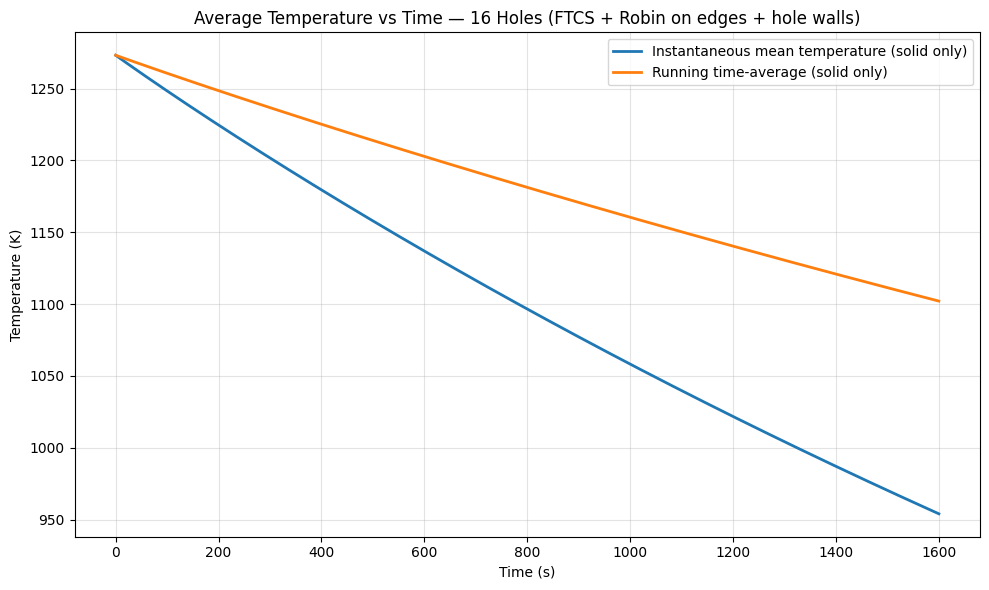

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# FTCS (explicit) 2D cooling of a 0.5m x 0.5m carbon-ceramic plate
# 16 circular holes (4x4), diameter = 1 cm
# Robin (convective) BC on:
#   - outer edges
#   - hole walls (solid/void interface via Robin ghost-neighbour)
#
# CHANGE INCORPORATED:
#   - Hole centres use a fixed edge margin = 0.05 m
#
# Outputs:
#   - Graph: instantaneous mean T (solid only) + running time-average
#   - Numeric evidence at t≈250 s and t≈500 s (solid-only mean)
# ============================================================

# -----------------------------
# Constants (carbon-ceramic)
# -----------------------------
rho = 1780
cp = 2218
k = 86.3                # W/(m K)
h = 100.0               # W/(m^2 K)
alpha = k / (rho * cp)          # m^2/s
T_init = 1273.15
T_inf  = 296.15

# -----------------------------
# Domain / grid
# -----------------------------
Lx = Ly = 0.5
Nx = Ny = 301
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)
assert abs(dx - dy) < 1e-15, "Assumes dx == dy."

x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y, indexing="ij")

# -----------------------------
# 16 holes (4x4), diameter 1 cm
# -----------------------------
holes_per_side = 4
r_hole = 0.005  # m (diameter 0.01 m)

edge_margin = 0.05  # m  <<< requested change
# Ensure holes do not intersect the outer boundary
assert edge_margin >= r_hole, "edge_margin must be >= hole radius to avoid touching edges."

# 4 evenly spaced centres from edge_margin to Lx-edge_margin
centers_1d = np.linspace(edge_margin, Lx - edge_margin, holes_per_side)
centers = [(cx, cy) for cx in centers_1d for cy in centers_1d]

hole = np.zeros((Nx, Ny), dtype=bool)
for (cx, cy) in centers:
    hole |= (X - cx)**2 + (Y - cy)**2 <= r_hole**2

solid = ~hole

# -----------------------------
# Time settings (FTCS stability)
# 2D FTCS with dx=dy: r = alpha*dt/dx^2 <= 0.25
# -----------------------------
t_end = 1600.0
dt_max = 0.25 * dx*dx / alpha
dt = 0.80 * dt_max
Nt = int(np.ceil(t_end / dt))
dt = t_end / Nt
r = alpha * dt / (dx*dx)

# Robin parameter beta = h*dx/k used in ghost neighbor
beta = (h * dx / k)

def robin_ghost(Tcell):
    return Tcell - beta * (Tcell - T_inf)

# -----------------------------
# Precompute interface masks (static)
# -----------------------------
solid_xp = np.zeros_like(solid); solid_xp[:-1, :] = solid[1:, :]
solid_xm = np.zeros_like(solid); solid_xm[1:,  :] = solid[:-1, :]
solid_yp = np.zeros_like(solid); solid_yp[:, :-1] = solid[:, 1:]
solid_ym = np.zeros_like(solid); solid_ym[:, 1: ] = solid[:, :-1]

need_xp = solid & (~solid_xp)
need_xm = solid & (~solid_xm)
need_yp = solid & (~solid_yp)
need_ym = solid & (~solid_ym)

# -----------------------------
# Initial condition
# -----------------------------
T = np.full((Nx, Ny), T_init, dtype=np.float64)
T[hole] = T_inf

# -----------------------------
# Storage for graph
# -----------------------------
times = np.arange(Nt+1, dtype=float) * dt
mean_solid = np.empty(Nt+1, dtype=float)
runavg_solid = np.empty(Nt+1, dtype=float)

mean_solid[0] = T[solid].mean()
runavg_solid[0] = mean_solid[0]
area = 0.0

# -----------------------------
# FTCS time stepping
# -----------------------------
for n in range(1, Nt+1):
    Tn = T.copy()

    # Neighbor arrays
    Txp = Tn.copy(); Txm = Tn.copy(); Typ = Tn.copy(); Tym = Tn.copy()
    Txp[:-1, :] = Tn[1:, :]
    Txm[1:,  :] = Tn[:-1, :]
    Typ[:, :-1] = Tn[:, 1:]
    Tym[:, 1: ] = Tn[:, :-1]

    # Outer edges Robin
    Txm[0, :]   = robin_ghost(Tn[0, :])
    Txp[-1, :]  = robin_ghost(Tn[-1, :])
    Tym[:, 0]   = robin_ghost(Tn[:, 0])
    Typ[:, -1]  = robin_ghost(Tn[:, -1])

    # Hole walls Robin (solid next to void)
    Txp[need_xp] = robin_ghost(Tn[need_xp])
    Txm[need_xm] = robin_ghost(Tn[need_xm])
    Typ[need_yp] = robin_ghost(Tn[need_yp])
    Tym[need_ym] = robin_ghost(Tn[need_ym])

    # Laplacian
    lap = (Txp + Txm + Typ + Tym - 4.0*Tn) / (dx*dx)

    # Update only solid; keep holes at ambient
    T = Tn.copy()
    T[solid] = Tn[solid] + alpha * dt * lap[solid]
    T[hole]  = T_inf

    mean_solid[n] = T[solid].mean()
    area += 0.5 * (mean_solid[n] + mean_solid[n-1]) * dt
    runavg_solid[n] = area / times[n] if times[n] > 0 else mean_solid[n]

print(f"Stability check: r={r:.6f} (must be <= 0.25) | dt={dt:.6f} s | Nt={Nt}")
print("Hole-centre edge margin used:", edge_margin, "m")
print("Hole centres (1D):", centers_1d)

def sample_at(t_query):
    idx = int(np.argmin(np.abs(times - t_query)))
    return times[idx], mean_solid[idx], runavg_solid[idx]

for tq in [250.0, 500.0]:
    tt, ms, ra = sample_at(tq)
    print(f"t≈{tt:.2f}s: mean_solid={ms:.3f} K | running_avg={ra:.3f} K")

plt.figure(figsize=(10, 6))
plt.plot(times, mean_solid, linewidth=2, label="Instantaneous mean temperature (solid only)")
plt.plot(times, runavg_solid, linewidth=2, label="Running time-average (solid only)")
plt.title("Average Temperature vs Time — 16 Holes (FTCS + Robin on edges + hole walls)")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.grid(True, alpha=0.35)
plt.legend()
plt.tight_layout()
plt.show()

Stability check (both cases): r=0.199999 (<=0.25) | dt=0.025415 | Nt=62954
t≈250.01s: mean_solid_16=1213.795 K | mean_solid_25=1204.922 K
t≈500.00s: mean_solid_16=1158.881 K | mean_solid_25=1142.200 K


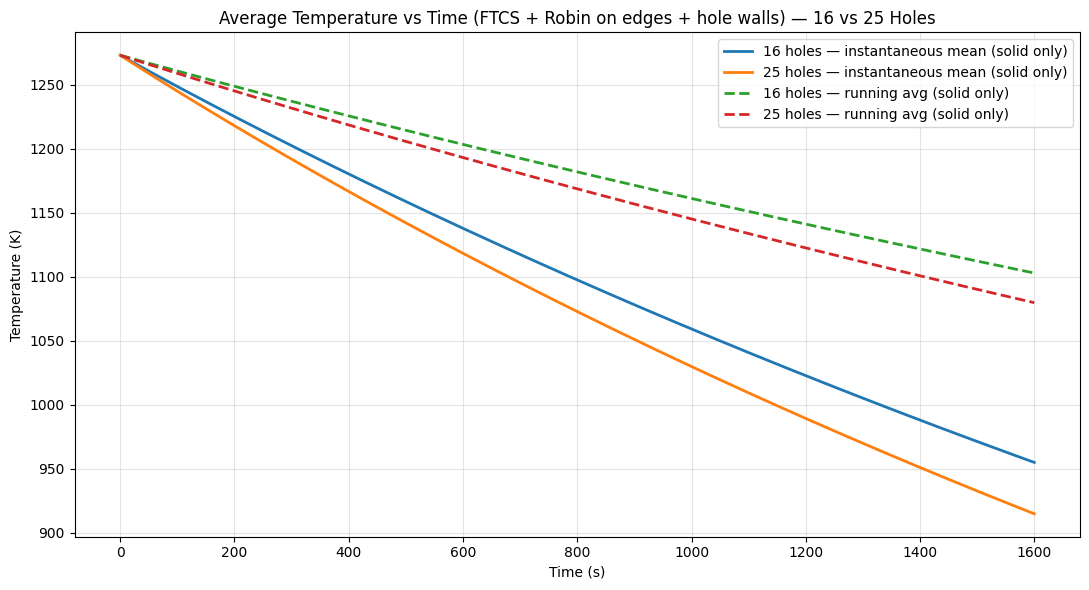

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# COMBINED: FTCS 16 holes vs 25 holes
# Same grid, same dt logic, same Robin BC implementation
# Plots: instantaneous mean (solid-only) for both + running averages
# Prints: solid-only mean at t≈250 s and t≈500 s for both
# ============================================================

rho = 1780
cp = 2218
k = 86.3                # W/(m K)
h = 100.0               # W/(m^2 K)
alpha = k / (rho * cp)          # m^2/s
T_init = 1273.15
T_inf  = 296.15

Lx = Ly = 0.5
Nx = Ny = 301
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)
assert abs(dx - dy) < 1e-15

x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y, indexing="ij")

t_end = 1600.0
dt_max = 0.25 * dx*dx / alpha
dt = 0.80 * dt_max
Nt = int(np.ceil(t_end / dt))
dt = t_end / Nt
r = alpha * dt / (dx*dx)

beta = (h * dx / k)
def robin_ghost(Tcell):
    return Tcell - beta * (Tcell - T_inf)

times = np.arange(Nt+1, dtype=float) * dt

def run_case(holes_per_side):
    # Build hole mask
    r_hole = 0.005
    centers_1d = np.linspace(Lx/(holes_per_side+1), Lx*holes_per_side/(holes_per_side+1), holes_per_side)
    centers = [(cx, cy) for cx in centers_1d for cy in centers_1d]

    hole = np.zeros((Nx, Ny), dtype=bool)
    for (cx, cy) in centers:
        hole |= (X - cx)**2 + (Y - cy)**2 <= r_hole**2
    solid = ~hole

    # Precompute interface masks
    solid_xp = np.zeros_like(solid); solid_xp[:-1, :] = solid[1:, :]
    solid_xm = np.zeros_like(solid); solid_xm[1:,  :] = solid[:-1, :]
    solid_yp = np.zeros_like(solid); solid_yp[:, :-1] = solid[:, 1:]
    solid_ym = np.zeros_like(solid); solid_ym[:, 1: ] = solid[:, :-1]

    need_xp = solid & (~solid_xp)
    need_xm = solid & (~solid_xm)
    need_yp = solid & (~solid_yp)
    need_ym = solid & (~solid_ym)

    # Initial
    T = np.full((Nx, Ny), T_init, dtype=np.float64)
    T[hole] = T_inf

    mean_solid = np.empty(Nt+1, dtype=float)
    runavg_solid = np.empty(Nt+1, dtype=float)

    mean_solid[0] = T[solid].mean()
    runavg_solid[0] = mean_solid[0]
    area = 0.0

    for n in range(1, Nt+1):
        Tn = T.copy()

        Txp = Tn.copy(); Txm = Tn.copy(); Typ = Tn.copy(); Tym = Tn.copy()
        Txp[:-1, :] = Tn[1:, :]
        Txm[1:,  :] = Tn[:-1, :]
        Typ[:, :-1] = Tn[:, 1:]
        Tym[:, 1: ] = Tn[:, :-1]

        # Outer edges Robin
        Txm[0, :]   = robin_ghost(Tn[0, :])
        Txp[-1, :]  = robin_ghost(Tn[-1, :])
        Tym[:, 0]   = robin_ghost(Tn[:, 0])
        Typ[:, -1]  = robin_ghost(Tn[:, -1])

        # Hole walls Robin
        Txp[need_xp] = robin_ghost(Tn[need_xp])
        Txm[need_xm] = robin_ghost(Tn[need_xm])
        Typ[need_yp] = robin_ghost(Tn[need_yp])
        Tym[need_ym] = robin_ghost(Tn[need_ym])

        lap = (Txp + Txm + Typ + Tym - 4.0*Tn) / (dx*dx)

        T = Tn.copy()
        T[solid] = Tn[solid] + alpha * dt * lap[solid]
        T[hole]  = T_inf

        mean_solid[n] = T[solid].mean()
        area += 0.5 * (mean_solid[n] + mean_solid[n-1]) * dt
        runavg_solid[n] = area / times[n] if times[n] > 0 else mean_solid[n]

    return mean_solid, runavg_solid

mean16, run16 = run_case(4)  # 4x4 = 16
mean25, run25 = run_case(5)  # 5x5 = 25

print(f"Stability check (both cases): r={r:.6f} (<=0.25) | dt={dt:.6f} | Nt={Nt}")

def sample(arr, t_query):
    idx = int(np.argmin(np.abs(times - t_query)))
    return times[idx], arr[idx]

for tq in [250.0, 500.0]:
    t16, m16 = sample(mean16, tq)
    t25, m25 = sample(mean25, tq)
    print(f"t≈{t16:.2f}s: mean_solid_16={m16:.3f} K | mean_solid_25={m25:.3f} K")

plt.figure(figsize=(11, 6))
plt.plot(times, mean16, linewidth=2, label="16 holes — instantaneous mean (solid only)")
plt.plot(times, mean25, linewidth=2, label="25 holes — instantaneous mean (solid only)")
plt.plot(times, run16,  linewidth=2, linestyle="--", label="16 holes — running avg (solid only)")
plt.plot(times, run25,  linewidth=2, linestyle="--", label="25 holes — running avg (solid only)")
plt.title("Average Temperature vs Time (FTCS + Robin on edges + hole walls) — 16 vs 25 Holes")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.grid(True, alpha=0.35)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# ============================================
# FTCS (explicit) 2D cooling of a 0.5m x 0.5m carbon-ceramic plate
# with 25 CIRCULAR holes (5x5 incl. centre), diameter = 1 cm
# Robin (convective) BC on:
#   - outer square edges
#   - hole boundaries (solid/void interface treated as Robin via ghost neighbor)
#
# Plotting-only improvement (THIS EDIT):
#   - Interpolate to fine grid WITHOUT mixing hole (void) temperatures into the solid near hole edges.
#     This removes the coloured artefact rim around holes and produces clean circular holes.
#   - Fine-grid hole mask is still used for perfect circular masking.
# Simulation grid/physics unchanged.
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Colab download helpers
try:
    from google.colab import files
    from IPython.display import FileLink, display
    IN_COLAB = True
except Exception:
    IN_COLAB = False

# -----------------------------
# Constants (carbon-ceramic)
# -----------------------------
rho = 1780
cp = 2218
k = 86.3                # W/(m K)
h = 100.0               # W/(m^2 K)
alpha = k / (rho * cp)  # m^2/s
T_init = 1273.15        # K
T_inf  = 296.15         # K

# -----------------------------
# Domain/grid (UNCHANGED)
# -----------------------------
Lx = Ly = 0.5
Nx = Ny = 301
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)
assert abs(dx - dy) < 1e-15, "This script assumes dx == dy."

x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y, indexing="ij")

# -----------------------------
# 25 circular holes (UNCHANGED)
# -----------------------------
r_hole = 0.005  # m
centers_1d = np.linspace(0.05, 0.45, 5)  # includes center 0.25
centers = [(cx, cy) for cx in centers_1d for cy in centers_1d]

hole = np.zeros((Nx, Ny), dtype=bool)
for (cx, cy) in centers:
    hole |= (X - cx)**2 + (Y - cy)**2 <= r_hole**2

solid = ~hole

# -----------------------------
# Time settings (FTCS stability) (UNCHANGED)
# -----------------------------
t_end = 3000.0
dt_max = 0.25 * dx*dx / alpha
dt = 0.80 * dt_max  # safety factor

Nt = int(np.ceil(t_end / dt))
dt = t_end / Nt     # adjust so final time hits exactly
r = alpha * dt / (dx*dx)

# Robin parameter (UNCHANGED)
beta = (h * dx / k)

# snapshots every 30 s INCLUDING 3000 (UNCHANGED)
snap_times = np.arange(0.0, t_end + 1e-9, 30.0)
snap_steps = {int(round(t/dt)): t for t in snap_times}

# -----------------------------
# Fixed colour scale (UNCHANGED)
# -----------------------------
vmin_fixed = T_inf
vmax_fixed = T_init
levels = np.linspace(vmin_fixed, vmax_fixed, 200)
cmap = plt.cm.plasma.copy()
cmap.set_bad(color="white")

# -----------------------------
# Initial condition (UNCHANGED)
# -----------------------------
T = np.full((Nx, Ny), T_init, dtype=np.float64)
T[hole] = T_inf

# -----------------------------
# Helper: Robin ghost neighbor value (UNCHANGED)
# -----------------------------
def robin_ghost(Tcell):
    return Tcell - beta * (Tcell - T_inf)

# ============================================================
# PLOTTING-ONLY: fine grid + mask-aware interpolation + exact hole mask
# ============================================================
PLOT_N = 900  # plotting only
xf = np.linspace(0.0, Lx, PLOT_N)
yf = np.linspace(0.0, Ly, PLOT_N)
Xf, Yf = np.meshgrid(xf, yf, indexing="ij")

hole_f = np.zeros((PLOT_N, PLOT_N), dtype=bool)
for (cx, cy) in centers:
    hole_f |= (Xf - cx)**2 + (Yf - cy)**2 <= r_hole**2
solid_f = ~hole_f

# ---- Precompute fine->coarse mapping (plotting only) ----
ix = (xf - x[0]) / dx
iy = (yf - y[0]) / dy
ix = np.clip(ix, 0.0, Nx - 1 - 1e-12)
iy = np.clip(iy, 0.0, Ny - 1 - 1e-12)

i0 = np.floor(ix).astype(np.int64)
j0 = np.floor(iy).astype(np.int64)
i1 = i0 + 1
j1 = j0 + 1

tx = (ix - i0).astype(np.float64)
ty = (iy - j0).astype(np.float64)

# Broadcast helpers
i0_2d = i0[:, None]
i1_2d = i1[:, None]
j0_2d = j0[None, :]
j1_2d = j1[None, :]

tx_2d = tx[:, None]
ty_2d = ty[None, :]

w00 = (1.0 - tx_2d) * (1.0 - ty_2d)
w10 = (tx_2d)       * (1.0 - ty_2d)
w01 = (1.0 - tx_2d) * (ty_2d)
w11 = (tx_2d)       * (ty_2d)

def masked_bilinear_interp_to_fine(Tcoarse, solid_coarse):
    """
    Plotting-only interpolation:
    - Uses bilinear weights but IGNORE neighbours that are holes/void.
    - Renormalises using only solid neighbours.
    This prevents 'rim' artefacts around holes.
    """
    # Coarse values
    T00 = Tcoarse[i0_2d, j0_2d]
    T10 = Tcoarse[i1_2d, j0_2d]
    T01 = Tcoarse[i0_2d, j1_2d]
    T11 = Tcoarse[i1_2d, j1_2d]

    # Coarse validity (solid only)
    V00 = solid_coarse[i0_2d, j0_2d]
    V10 = solid_coarse[i1_2d, j0_2d]
    V01 = solid_coarse[i0_2d, j1_2d]
    V11 = solid_coarse[i1_2d, j1_2d]

    # Convert bool to float weights
    V00f = V00.astype(np.float64)
    V10f = V10.astype(np.float64)
    V01f = V01.astype(np.float64)
    V11f = V11.astype(np.float64)

    # Weighted sum over solid neighbours only
    num = (w00 * V00f * T00 +
           w10 * V10f * T10 +
           w01 * V01f * T01 +
           w11 * V11f * T11)

    den = (w00 * V00f +
           w10 * V10f +
           w01 * V01f +
           w11 * V11f)

    Tf = np.empty((PLOT_N, PLOT_N), dtype=np.float64)
    Tf[:] = np.nan
    np.divide(num, den, out=Tf, where=(den > 0.0))
    return Tf

# -----------------------------
# Output
# -----------------------------
out_pdf = "FTCS_25holes_robin_3000s.pdf"

with PdfPages(out_pdf) as pdf:
    for n in range(Nt + 1):

        # ---- Save snapshot BEFORE stepping ----
        if n in snap_steps:
            t = snap_steps[n]

            # Plotting-only: interpolate to fine grid WITHOUT hole contamination
            Tf = masked_bilinear_interp_to_fine(T, solid)
            # Apply exact fine mask for perfectly circular holes
            Tf_plot = np.where(solid_f, Tf, np.nan)

            fig = plt.figure(figsize=(6.8, 5.8), dpi=220)
            ax = plt.gca()

            cf = ax.contourf(
                Xf, Yf, Tf_plot,
                levels=levels, vmin=vmin_fixed, vmax=vmax_fixed, cmap=cmap
            )

            ax.set_aspect("equal")
            ax.set_xlim(0, Lx); ax.set_ylim(0, Ly)
            ax.set_xlabel("x (m)")
            ax.set_ylabel("y (m)")
            ax.set_title(f"Temperature at t = {int(round(t))} s (FTCS, Robin edges + hole walls)")
            ax.grid(True, linestyle="--", alpha=0.30)

            cb = plt.colorbar(cf)
            cb.set_label("Temperature (K)")
            cb.set_ticks(np.linspace(vmin_fixed, vmax_fixed, 10))

            pdf.savefig(fig)
            plt.close(fig)

        if n == Nt:
            break

        # ---- FTCS step with Robin edges + Robin hole walls (UNCHANGED) ----
        Tn = T.copy()

        # Neighbor arrays
        Txp = Tn.copy(); Txm = Tn.copy(); Typ = Tn.copy(); Tym = Tn.copy()
        Txp[:-1, :] = Tn[1:, :]
        Txm[1:,  :] = Tn[:-1, :]
        Typ[:, :-1] = Tn[:, 1:]
        Tym[:, 1: ] = Tn[:, :-1]

        # Outer edges: Robin ghosts
        Txm[0, :]   = robin_ghost(Tn[0, :])
        Txp[-1, :]  = robin_ghost(Tn[-1, :])
        Tym[:, 0]   = robin_ghost(Tn[:, 0])
        Typ[:, -1]  = robin_ghost(Tn[:, -1])

        # Hole walls: if neighbor is void, replace that neighbor by Robin ghost
        solid_xp = np.zeros_like(solid); solid_xp[:-1, :] = solid[1:, :]
        solid_xm = np.zeros_like(solid); solid_xm[1:,  :] = solid[:-1, :]
        solid_yp = np.zeros_like(solid); solid_yp[:, :-1] = solid[:, 1:]
        solid_ym = np.zeros_like(solid); solid_ym[:, 1: ] = solid[:, :-1]

        need_xp = solid & (~solid_xp)
        need_xm = solid & (~solid_xm)
        need_yp = solid & (~solid_yp)
        need_ym = solid & (~solid_ym)

        Txp[need_xp] = robin_ghost(Tn[need_xp])
        Txm[need_xm] = robin_ghost(Tn[need_xm])
        Typ[need_yp] = robin_ghost(Tn[need_yp])
        Tym[need_ym] = robin_ghost(Tn[need_ym])

        lap = (Txp + Txm + Typ + Tym - 4.0*Tn) / (dx*dx)

        # Update only solid; keep holes at ambient
        T = Tn.copy()
        T[solid] = Tn[solid] + alpha * dt * lap[solid]
        T[hole] = T_inf

print("Saved:", out_pdf)
print(f"Nx=Ny={Nx}, dx={dx:.6e} m, dt={dt:.6f} s, Nt={Nt}, r={r:.6f} (must be <= 0.25)")
print("Holes: 25 (5x5 evenly distributed), diameter = 0.01 m")

if IN_COLAB:
    display(FileLink(out_pdf))
    files.download(out_pdf)

Saved: FTCS_25holes_robin_3000s.pdf
Nx=Ny=301, dx=1.666667e-03 m, dt=0.025415 s, Nt=118039, r=0.199999 (must be <= 0.25)
Holes: 25 (5x5 evenly distributed), diameter = 0.01 m


/content/FTCS_25holes_robin_3000s.pdf

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 2D transient heat diffusion on a 0.5m x 0.5m plate
# FTCS + Robin BC on outer edges + Robin on 16 hole walls (solid/void interface)
# Snapshots every 30 s from t=0 to t=1590, total sim time 1600 s
# Consistent color scale across all frames
#
# PLOTTING-ONLY CHANGES (to get perfectly circular holes + remove edge artefacts):
# - Interpolate on a fine grid
# - Build an analytic fine-grid circular hole mask
# - IMPORTANT: for plotting interpolation only, fill hole cells with nearby SOLID values
#   so bilinear interpolation does not blend T_inf from holes into the solid (removes artefacts)
# - Keep isotherm contour lines
# - Rasterize plot artists for clean PDFs

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Colab download helpers
try:
    from google.colab import files
    from IPython.display import FileLink, display
    IN_COLAB = True
except Exception:
    IN_COLAB = False

# -----------------------------
# Given constants (as in your code)
# -----------------------------
rho = 1780
cp  = 2218
k   = 86.3                # W/(m K)
h   = 100.0               # W/(m^2 K)
alpha = k / (rho * cp)    # m^2/s

T_init = 1273.15          # K
T_inf  = 296.15           # K

# -----------------------------
# Domain / grid (UNCHANGED)
# -----------------------------
Lx = Ly = 0.5
Nx = Ny = 81
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y, indexing="ij")

# -----------------------------
# FTCS stability (UNCHANGED)
# -----------------------------
dt_max = 0.25 * min(dx, dy)**2 / alpha
dt = 0.80 * dt_max

t_end = 1600.0
Nt = int(np.ceil(t_end/dt))
dt = t_end/Nt

# -----------------------------
# Snapshot schedule (UNCHANGED)
# -----------------------------
snap_times = np.arange(0.0, 1600.0, 30.0)  # 0,30,...,1590
snap_steps = {int(round(t/dt)): t for t in snap_times}

# -----------------------------
# Robin boundary via ghost cell (UNCHANGED)
# -----------------------------
def robin_ghost(Tcell, d):
    return Tcell - (h*d/k)*(Tcell - T_inf)

# -----------------------------
# Fixed, consistent color scale (UNCHANGED)
# -----------------------------
vmin_fixed = T_inf
vmax_fixed = T_init
N_LEVELS = 90
levels = np.linspace(vmin_fixed, vmax_fixed, N_LEVELS)
cmap = plt.cm.plasma

# -----------------------------
# Initial condition (UNCHANGED)
# -----------------------------
T = np.full((Nx, Ny), T_init, dtype=float)

# ==========================================================
# 16 evenly distributed CIRCULAR perforations (UNCHANGED)
# ==========================================================
holes_per_side = 4
hole_diameter = 0.01  # m
hole_radius = 0.5 * hole_diameter

xs = np.linspace(Lx/(holes_per_side+1), Lx*holes_per_side/(holes_per_side+1), holes_per_side)
ys = np.linspace(Ly/(holes_per_side+1), Ly*holes_per_side/(holes_per_side+1), holes_per_side)
hole_centers = [(xc, yc) for xc in xs for yc in ys]

solid = np.ones((Nx, Ny), dtype=bool)
for (xc, yc) in hole_centers:
    solid &= (((X - xc)**2 + (Y - yc)**2) > hole_radius**2)

T[~solid] = T_inf

# ============================================================
# PLOTTING-ONLY: fine grid + analytic circular hole mask
# ============================================================
PLOT_N = 900  # higher => smoother circles (plotting only)
xf = np.linspace(0.0, Lx, PLOT_N)
yf = np.linspace(0.0, Ly, PLOT_N)
Xf, Yf = np.meshgrid(xf, yf, indexing="ij")

hole_f = np.zeros((PLOT_N, PLOT_N), dtype=bool)
for (xc, yc) in hole_centers:
    hole_f |= (((Xf - xc)**2 + (Yf - yc)**2) <= hole_radius**2)
solid_f = ~hole_f

def bilinear_interp_to_fine(Tcoarse, xf, yf):
    ix = (xf - x[0]) / dx
    iy = (yf - y[0]) / dy
    ix = np.clip(ix, 0.0, Nx - 1 - 1e-12)
    iy = np.clip(iy, 0.0, Ny - 1 - 1e-12)

    i0 = np.floor(ix).astype(np.int64)
    j0 = np.floor(iy).astype(np.int64)
    i1 = i0 + 1
    j1 = j0 + 1

    tx = (ix - i0).astype(np.float64)
    ty = (iy - j0).astype(np.float64)

    i0_2d = i0[:, None]
    i1_2d = i1[:, None]
    j0_2d = j0[None, :]
    j1_2d = j1[None, :]

    tx_2d = tx[:, None]
    ty_2d = ty[None, :]

    T00 = Tcoarse[i0_2d, j0_2d]
    T10 = Tcoarse[i1_2d, j0_2d]
    T01 = Tcoarse[i0_2d, j1_2d]
    T11 = Tcoarse[i1_2d, j1_2d]

    return ((1 - tx_2d) * (1 - ty_2d) * T00 +
            (tx_2d)     * (1 - ty_2d) * T10 +
            (1 - tx_2d) * (ty_2d)     * T01 +
            (tx_2d)     * (ty_2d)     * T11)

# -----------------------------
# PLOTTING-ONLY: fill hole cells with nearby solid values (removes edge artefacts)
# -----------------------------
def fill_holes_for_plot(Tcoarse, solid_mask, max_iters=200):
    """
    Returns a copy of Tcoarse where non-solid (holes) are filled using neighboring solid temps.
    This is ONLY for plotting interpolation, to prevent bilinear blending of T_inf into solid.
    """
    A = Tcoarse.copy()
    A[~solid_mask] = np.nan

    # Iteratively fill NaNs using available 4-neighbor averages
    for _ in range(max_iters):
        nanmask = np.isnan(A)
        if not nanmask.any():
            break

        # neighbors (use edge replication; only updates where currently nan)
        Axp = np.roll(A, -1, axis=0)
        Axm = np.roll(A,  1, axis=0)
        Ayp = np.roll(A, -1, axis=1)
        Aym = np.roll(A,  1, axis=1)

        # prevent wrap-around influence at boundaries
        Axp[-1, :] = np.nan
        Axm[ 0, :] = np.nan
        Ayp[:, -1] = np.nan
        Aym[:,  0] = np.nan

        neigh = np.stack([Axp, Axm, Ayp, Aym], axis=0)
        count = np.sum(~np.isnan(neigh), axis=0)
        meanv = np.nanmean(neigh, axis=0)

        can_fill = nanmask & (count > 0)
        if not np.any(can_fill):
            break
        A[can_fill] = meanv[can_fill]

    # Any remaining NaNs (shouldn't happen for interior holes) fallback to T_inf
    A[np.isnan(A)] = T_inf
    return A

# -----------------------------
# Output
# -----------------------------
out_pdf = "carbon_ceramic_plate_robin_1000s.pdf"
FIG_DPI = 220

with PdfPages(out_pdf) as pdf:
    for n in range(Nt + 1):

        # ---- Save snapshot BEFORE stepping ----
        if n in snap_steps:
            t = snap_steps[n]

            # PLOTTING-ONLY: prevent artefacts by filling holes before interpolation
            T_for_plot = fill_holes_for_plot(T, solid)

            Tf = bilinear_interp_to_fine(T_for_plot, xf, yf)
            Tf_plot = np.where(solid_f, Tf, np.nan)

            fig = plt.figure(figsize=(6, 5), dpi=FIG_DPI)
            ax = plt.gca()

            # Use imshow for the field (clean raster), and contour for isotherms
            Tf_masked = np.ma.masked_invalid(Tf_plot)
            im = ax.imshow(
                Tf_masked.T,
                extent=[0.0, Lx, 0.0, Ly],
                origin="lower",
                cmap=cmap,
                vmin=vmin_fixed,
                vmax=vmax_fixed,
                interpolation="bilinear"
            )

            # Isotherms (skip if field is essentially uniform)
            finite_vals = Tf_plot[np.isfinite(Tf_plot)]
            if finite_vals.size > 0 and (finite_vals.max() - finite_vals.min()) > 1e-6:
                cs = ax.contour(
                    Xf, Yf, Tf_plot,
                    levels=60, colors="w", alpha=0.18, linewidths=0.6
                )
                if hasattr(cs, "set_rasterized"):
                    cs.set_rasterized(True)

            # Rasterize image artist for crisp PDF
            if hasattr(im, "set_rasterized"):
                im.set_rasterized(True)

            ax.set_aspect("equal")
            ax.set_xlim(0, Lx); ax.set_ylim(0, Ly)
            ax.set_xlabel("x (m)")
            ax.set_ylabel("y (m)")
            ax.set_title(f"Temperature at t = {int(round(t))} s (FTCS, Robin edges + hole walls)")
            ax.grid(True, linestyle="--", alpha=0.4)

            cb = plt.colorbar(im)
            cb.set_label("Temperature (K)")
            cb.set_ticks(np.linspace(vmin_fixed, vmax_fixed, 10))

            pdf.savefig(fig)
            plt.close(fig)

        if n == Nt:
            break

        # ---- FTCS step with Robin edges + Robin hole walls (UNCHANGED) ----
        Tn = T.copy()

        Txp = Tn.copy(); Txm = Tn.copy(); Typ = Tn.copy(); Tym = Tn.copy()
        Txp[:-1, :] = Tn[1:, :]
        Txm[1:,  :] = Tn[:-1, :]
        Typ[:, :-1] = Tn[:, 1:]
        Tym[:, 1: ] = Tn[:, :-1]

        # Outer edges: Robin ghosts
        Txm[0, :]   = robin_ghost(Tn[0, :], dx)
        Txp[-1, :]  = robin_ghost(Tn[-1, :], dx)
        Tym[:, 0]   = robin_ghost(Tn[:, 0], dy)
        Typ[:, -1]  = robin_ghost(Tn[:, -1], dy)

        # Hole walls: neighbor is void -> Robin ghost
        solid_xp = np.zeros_like(solid); solid_xp[:-1, :] = solid[1:, :]
        solid_xm = np.zeros_like(solid); solid_xm[1:,  :] = solid[:-1, :]
        solid_yp = np.zeros_like(solid); solid_yp[:, :-1] = solid[:, 1:]
        solid_ym = np.zeros_like(solid); solid_ym[:, 1: ] = solid[:, :-1]

        need_xp = solid & (~solid_xp)
        need_xm = solid & (~solid_xm)
        need_yp = solid & (~solid_yp)
        need_ym = solid & (~solid_ym)

        Txp[need_xp] = robin_ghost(Tn[need_xp], dx)
        Txm[need_xm] = robin_ghost(Tn[need_xm], dx)
        Typ[need_yp] = robin_ghost(Tn[need_yp], dy)
        Tym[need_ym] = robin_ghost(Tn[need_ym], dy)

        lap = (Txp + Txm + Typ + Tym - 4.0*Tn) / (dx*dx)

        T = Tn.copy()
        T[solid] = Tn[solid] + alpha * dt * lap[solid]
        T[~solid] = T_inf

print("Saved:", out_pdf)
print(f"Nx=Ny={Nx}, dt={dt:.6f} s, Nt={Nt}, final time={Nt*dt:.2f} s")
print("Holes: 16 (4x4 evenly distributed), diameter =", hole_diameter, "m")

if IN_COLAB:
    display(FileLink(out_pdf))
    files.download(out_pdf)

/tmp/ipython-input-2441024426.py:232: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x7e0d4bec4980>' will be ignored
  cs.set_rasterized(True)
/tmp/ipython-input-2441024426.py:232: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x7e0d4a496bd0>' will be ignored
  cs.set_rasterized(True)
/tmp/ipython-input-2441024426.py:232: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x7e0d4a54b950>' will be ignored
  cs.set_rasterized(True)
/tmp/ipython-input-2441024426.py:232: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x7e0d4815b950>' will be ignored
  cs.set_rasterized(True)
/tmp/ipython-input-2441024426.py:232: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x7e0d50248440>' will be ignored
  cs.set_rasterized(True)
/tmp/ipython-input-2441024426.py:232: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x7e0d501d3950>' will

Saved: carbon_ceramic_plate_robin_1000s.pdf
Nx=Ny=81, dt=0.357382 s, Nt=4477, final time=1600.00 s
Holes: 16 (4x4 evenly distributed), diameter = 0.01 m


/content/carbon_ceramic_plate_robin_1000s.pdf

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ============================================
# FTCS (explicit) 2D cooling of a 0.5m x 0.5m plate
# with 25 CIRCULAR holes (5x5 incl. centre), diameter = 1 cm
# Robin (convective) BC on:
#   - outer square edges
#   - hole boundaries (solid/void interface treated as Robin via ghost neighbor)
#
# Plotting-only improvement:
#   - Interpolate to fine grid WITHOUT mixing hole (void) temperatures into the solid near hole edges
#     (removes coloured artefact rims).
#   - Overlay FILLED white Circle patches to guarantee perfectly circular holes (no jagged/square look).
#   - Keep isotherm (contour) lines.
#
# Simulation grid/physics unchanged.
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Circle

# Colab download helpers
try:
    from google.colab import files
    from IPython.display import FileLink, display
    IN_COLAB = True
except Exception:
    IN_COLAB = False

# -----------------------------
# Constants
# -----------------------------
rho = 1780.0
cp  = 2218.0
k   = 86.3                 # W/(m K)
h   = 100.0                # W/(m^2 K)
alpha = k / (rho * cp)     # m^2/s

T_init = 1273.15           # K
T_inf  = 296.15            # K

# -----------------------------
# Domain/grid (UNCHANGED)
# -----------------------------
Lx = Ly = 0.5
Nx = Ny = 301
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)
assert abs(dx - dy) < 1e-15, "This script assumes dx == dy."

x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y, indexing="ij")

# -----------------------------
# 25 circular holes (UNCHANGED geometry)
# -----------------------------
r_hole = 0.005  # m
centers_1d = np.linspace(0.05, 0.45, 5)  # includes center 0.25
centers = [(cx, cy) for cx in centers_1d for cy in centers_1d]

hole = np.zeros((Nx, Ny), dtype=bool)
for (cx, cy) in centers:
    hole |= (X - cx)**2 + (Y - cy)**2 <= r_hole**2

solid = ~hole

# -----------------------------
# Time settings (FTCS stability) (UNCHANGED)
# -----------------------------
t_end = 3000.0
dt_max = 0.25 * dx*dx / alpha
dt = 0.80 * dt_max  # safety factor

Nt = int(np.ceil(t_end / dt))
dt = t_end / Nt
r = alpha * dt / (dx*dx)

# Robin parameter (UNCHANGED)
beta = (h * dx / k)

# snapshots every 30 s INCLUDING 3000 (UNCHANGED)
snap_times = np.arange(0.0, t_end + 1e-9, 30.0)
snap_steps = {int(round(t/dt)): t for t in snap_times}

# -----------------------------
# Fixed colour scale (UNCHANGED)
# -----------------------------
vmin_fixed = T_inf
vmax_fixed = T_init
levels = np.linspace(vmin_fixed, vmax_fixed, 200)
cmap = plt.cm.plasma.copy()
cmap.set_bad(color="white")

# -----------------------------
# Initial condition (UNCHANGED)
# -----------------------------
T = np.full((Nx, Ny), T_init, dtype=np.float64)
T[hole] = T_inf

# -----------------------------
# Helper: Robin ghost neighbor value (UNCHANGED)
# -----------------------------
def robin_ghost(Tcell):
    return Tcell - beta * (Tcell - T_inf)

# -----------------------------
# Precompute hole-interface masks ONCE (efficiency; physics unchanged)
# -----------------------------
solid_xp = np.zeros_like(solid); solid_xp[:-1, :] = solid[1:, :]
solid_xm = np.zeros_like(solid); solid_xm[1:,  :] = solid[:-1, :]
solid_yp = np.zeros_like(solid); solid_yp[:, :-1] = solid[:, 1:]
solid_ym = np.zeros_like(solid); solid_ym[:, 1: ] = solid[:, :-1]

need_xp = solid & (~solid_xp)
need_xm = solid & (~solid_xm)
need_yp = solid & (~solid_yp)
need_ym = solid & (~solid_ym)

# ============================================================
# PLOTTING-ONLY: fine grid + mask-aware interpolation + exact hole mask
# ============================================================
PLOT_N = 900
xf = np.linspace(0.0, Lx, PLOT_N)
yf = np.linspace(0.0, Ly, PLOT_N)
Xf, Yf = np.meshgrid(xf, yf, indexing="ij")

hole_f = np.zeros((PLOT_N, PLOT_N), dtype=bool)
for (cx, cy) in centers:
    hole_f |= (Xf - cx)**2 + (Yf - cy)**2 <= r_hole**2
solid_f = ~hole_f

# ---- Precompute fine->coarse mapping (plotting only) ----
ix = (xf - x[0]) / dx
iy = (yf - y[0]) / dy
ix = np.clip(ix, 0.0, Nx - 1 - 1e-12)
iy = np.clip(iy, 0.0, Ny - 1 - 1e-12)

i0 = np.floor(ix).astype(np.int64)
j0 = np.floor(iy).astype(np.int64)
i1 = i0 + 1
j1 = j0 + 1

tx = (ix - i0).astype(np.float64)
ty = (iy - j0).astype(np.float64)

i0_2d = i0[:, None]
i1_2d = i1[:, None]
j0_2d = j0[None, :]
j1_2d = j1[None, :]

tx_2d = tx[:, None]
ty_2d = ty[None, :]

w00 = (1.0 - tx_2d) * (1.0 - ty_2d)
w10 = (tx_2d)       * (1.0 - ty_2d)
w01 = (1.0 - tx_2d) * (ty_2d)
w11 = (tx_2d)       * (ty_2d)

def masked_bilinear_interp_to_fine(Tcoarse, solid_coarse):
    """
    Plotting-only interpolation:
    - Bilinear weights, but ignore any neighbour that is a hole/void.
    - Renormalise using only solid neighbours.
    This prevents coloured 'rim' artefacts around holes.
    """
    T00 = Tcoarse[i0_2d, j0_2d]
    T10 = Tcoarse[i1_2d, j0_2d]
    T01 = Tcoarse[i0_2d, j1_2d]
    T11 = Tcoarse[i1_2d, j1_2d]

    V00 = solid_coarse[i0_2d, j0_2d].astype(np.float64)
    V10 = solid_coarse[i1_2d, j0_2d].astype(np.float64)
    V01 = solid_coarse[i0_2d, j1_2d].astype(np.float64)
    V11 = solid_coarse[i1_2d, j1_2d].astype(np.float64)

    num = (w00 * V00 * T00 +
           w10 * V10 * T10 +
           w01 * V01 * T01 +
           w11 * V11 * T11)

    den = (w00 * V00 +
           w10 * V10 +
           w01 * V01 +
           w11 * V11)

    Tf = np.empty((PLOT_N, PLOT_N), dtype=np.float64)
    Tf[:] = np.nan
    np.divide(num, den, out=Tf, where=(den > 0.0))
    return Tf

# -----------------------------
# Output
# -----------------------------
out_pdf = "FTCS_25holes_robin_3000s.pdf"

with PdfPages(out_pdf) as pdf:
    for n in range(Nt + 1):

        # ---- Save snapshot BEFORE stepping ----
        if n in snap_steps:
            t = snap_steps[n]

            # Plotting-only: interpolate to fine grid WITHOUT hole contamination
            Tf = masked_bilinear_interp_to_fine(T, solid)
            Tf_plot = np.where(solid_f, Tf, np.nan)

            fig = plt.figure(figsize=(6.8, 5.8), dpi=220)
            ax = plt.gca()

            cf = ax.contourf(
                Xf, Yf, Tf_plot,
                levels=levels, vmin=vmin_fixed, vmax=vmax_fixed, cmap=cmap
            )

            # Isotherm lines (keep)
            cs = ax.contour(
                Xf, Yf, Tf_plot,
                levels=60, colors="w", alpha=0.18, linewidths=0.6
            )
            # (optional) rasterize contours for PDF cleanliness
            if hasattr(cf, "set_rasterized"):
                cf.set_rasterized(True)
            if hasattr(cs, "set_rasterized"):
                cs.set_rasterized(True)

            # Perfectly circular holes (NO outline, pure white fill)
            for (cx, cy) in centers:
                ax.add_patch(Circle((cx, cy), r_hole,
                                    facecolor="white", edgecolor="white",
                                    linewidth=0.0, zorder=10))

            ax.set_aspect("equal")
            ax.set_xlim(0, Lx); ax.set_ylim(0, Ly)
            ax.set_xlabel("x (m)")
            ax.set_ylabel("y (m)")
            ax.set_title(f"Temperature at t = {int(round(t))} s (FTCS, Robin edges + hole walls)")
            ax.grid(True, linestyle="--", alpha=0.30)

            cb = plt.colorbar(cf)
            cb.set_label("Temperature (K)")
            cb.set_ticks(np.linspace(vmin_fixed, vmax_fixed, 10))

            pdf.savefig(fig)
            plt.close(fig)

        if n == Nt:
            break

        # ---- FTCS step with Robin edges + Robin hole walls (UNCHANGED physics) ----
        Tn = T

        # Neighbor arrays (avoid extra full copies)
        Txp = np.empty_like(Tn); Txm = np.empty_like(Tn)
        Typ = np.empty_like(Tn); Tym = np.empty_like(Tn)

        Txp[:-1, :] = Tn[1:, :]
        Txp[-1,  :] = robin_ghost(Tn[-1, :])   # outer right edge ghost

        Txm[1:,  :] = Tn[:-1, :]
        Txm[0,   :] = robin_ghost(Tn[0, :])    # outer left edge ghost

        Typ[:, :-1] = Tn[:, 1:]
        Typ[:, -1 ] = robin_ghost(Tn[:, -1])   # outer top edge ghost

        Tym[:, 1: ] = Tn[:, :-1]
        Tym[:, 0  ] = robin_ghost(Tn[:, 0])    # outer bottom edge ghost

        # Hole walls: if neighbour is void, replace neighbour by Robin ghost
        Txp[need_xp] = robin_ghost(Tn[need_xp])
        Txm[need_xm] = robin_ghost(Tn[need_xm])
        Typ[need_yp] = robin_ghost(Tn[need_yp])
        Tym[need_ym] = robin_ghost(Tn[need_ym])

        lap = (Txp + Txm + Typ + Tym - 4.0*Tn) / (dx*dx)

        # Update only solid; keep holes at ambient
        T = Tn.copy()
        T[solid] = Tn[solid] + alpha * dt * lap[solid]
        T[hole]  = T_inf

print("Saved:", out_pdf)
print(f"Nx=Ny={Nx}, dx={dx:.6e} m, dt={dt:.6f} s, Nt={Nt}, r={r:.6f} (must be <= 0.25)")
print("Holes: 25 (5x5 evenly distributed), diameter = 0.01 m")

if IN_COLAB:
    display(FileLink(out_pdf))
    files.download(out_pdf)

/tmp/ipython-input-3747301050.py:223: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x7e0d48734ec0>' will be ignored
  cf.set_rasterized(True)
/tmp/ipython-input-3747301050.py:225: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x7e0d4bd5b500>' will be ignored
  cs.set_rasterized(True)
/tmp/ipython-input-3747301050.py:223: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x7e0d48ef7f20>' will be ignored
  cf.set_rasterized(True)
/tmp/ipython-input-3747301050.py:225: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x7e0d45c66900>' will be ignored
  cs.set_rasterized(True)
/tmp/ipython-input-3747301050.py:223: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x7e0d4859a8d0>' will be ignored
  cf.set_rasterized(True)
/tmp/ipython-input-3747301050.py:225: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x7e0d4adf8b60>' will

Saved: FTCS_25holes_robin_3000s.pdf
Nx=Ny=301, dx=1.666667e-03 m, dt=0.025415 s, Nt=118039, r=0.199999 (must be <= 0.25)
Holes: 25 (5x5 evenly distributed), diameter = 0.01 m


/content/FTCS_25holes_robin_3000s.pdf

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ============================================
# FTCS (explicit) 2D cooling of a 0.5m x 0.5m plate
# with 25 circular holes (5x5), diameter = 1 cm
# Robin (convective) BC on:
#   - outer square edges
#   - hole boundaries (solid/void interface treated as Robin via ghost neighbor)
#
# Plotting-only improvement:
#   - Fine-grid solid-only interpolation (no hole contamination)
#   - Use imshow for the filled temperature map (removes contourf triangulation artifacts)
#   - Overlay isotherms with contour (keeps isotherm lines)
#   - Overlay filled Circle patches (white, NO edge) for perfectly circular holes
#   - PLOTTING-ONLY symmetry enforcement (nan-mean of 4 reflections) to remove any
#     tiny visual asymmetry caused by masking/interpolation/contouring (PHYSICS UNCHANGED)
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Circle

# Colab download helpers
try:
    from google.colab import files
    from IPython.display import FileLink, display
    IN_COLAB = True
except Exception:
    IN_COLAB = False

# -----------------------------
# Constants (as given)
# -----------------------------
rho = 1780.0
cp  = 2218.0
k   = 86.3               # W/(m K)
h   = 100.0              # W/(m^2 K)
alpha = k / (rho * cp)   # m^2/s

T_init = 1273.15         # K
T_inf  = 296.15          # K

# -----------------------------
# Domain/grid (UNCHANGED)
# -----------------------------
Lx = Ly = 0.5
Nx = Ny = 301
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)
assert abs(dx - dy) < 1e-15, "This script assumes dx == dy."

x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y, indexing="ij")

# -----------------------------
# 25 circular holes (UNCHANGED)
# -----------------------------
r_hole = 0.005  # m (diameter 0.01 m)
centers_1d = np.linspace(0.05, 0.45, 5)
centers = [(cx, cy) for cx in centers_1d for cy in centers_1d]

hole = np.zeros((Nx, Ny), dtype=bool)
for (cx, cy) in centers:
    hole |= (X - cx)**2 + (Y - cy)**2 <= r_hole**2

solid = ~hole

# -----------------------------
# Time settings (FTCS stability) (UNCHANGED)
# -----------------------------
t_end = 3000.0
dt_max = 0.25 * dx*dx / alpha
dt = 0.80 * dt_max  # safety factor

Nt = int(np.ceil(t_end / dt))
dt = t_end / Nt
r  = alpha * dt / (dx*dx)

# Robin parameter (UNCHANGED)
beta = (h * dx / k)

# snapshots every 30 s INCLUDING 3000 (UNCHANGED)
snap_times = np.arange(0.0, t_end + 1e-9, 30.0)
snap_steps = {int(round(t/dt)): t for t in snap_times}

# -----------------------------
# Fixed colour scale (UNCHANGED)
# -----------------------------
vmin_fixed = T_inf
vmax_fixed = T_init
cmap = plt.cm.plasma.copy()
cmap.set_bad(color="white")

# -----------------------------
# Initial condition (UNCHANGED)
# -----------------------------
T = np.full((Nx, Ny), T_init, dtype=np.float64)
T[hole] = T_inf

# -----------------------------
# Robin ghost neighbor value (UNCHANGED)
# -----------------------------
def robin_ghost(Tcell):
    return Tcell - beta * (Tcell - T_inf)

# -----------------------------
# Precompute static hole-interface masks (EFFICIENCY; PHYSICS UNCHANGED)
# -----------------------------
solid_xp = np.zeros_like(solid); solid_xp[:-1, :] = solid[1:, :]
solid_xm = np.zeros_like(solid); solid_xm[1:,  :] = solid[:-1, :]
solid_yp = np.zeros_like(solid); solid_yp[:, :-1] = solid[:, 1:]
solid_ym = np.zeros_like(solid); solid_ym[:, 1: ] = solid[:, :-1]

need_xp = solid & (~solid_xp)
need_xm = solid & (~solid_xm)
need_yp = solid & (~solid_yp)
need_ym = solid & (~solid_ym)

# ============================================================
# PLOTTING-ONLY: fine grid + mask-aware interpolation
# ============================================================
PLOT_N = 900
xf = np.linspace(0.0, Lx, PLOT_N)
yf = np.linspace(0.0, Ly, PLOT_N)
Xf, Yf = np.meshgrid(xf, yf, indexing="ij")

# Fine-grid mask for perfect circles
hole_f = np.zeros((PLOT_N, PLOT_N), dtype=bool)
for (cx, cy) in centers:
    hole_f |= (Xf - cx)**2 + (Yf - cy)**2 <= r_hole**2
solid_f = ~hole_f

# Precompute fine->coarse bilinear mapping (plotting-only)
ix = (xf - x[0]) / dx
iy = (yf - y[0]) / dy
ix = np.clip(ix, 0.0, Nx - 1 - 1e-12)
iy = np.clip(iy, 0.0, Ny - 1 - 1e-12)

i0 = np.floor(ix).astype(np.int64)
j0 = np.floor(iy).astype(np.int64)
i1 = i0 + 1
j1 = j0 + 1

tx = (ix - i0).astype(np.float64)
ty = (iy - j0).astype(np.float64)

i0_2d = i0[:, None]
i1_2d = i1[:, None]
j0_2d = j0[None, :]
j1_2d = j1[None, :]

tx_2d = tx[:, None]
ty_2d = ty[None, :]

w00 = (1.0 - tx_2d) * (1.0 - ty_2d)
w10 = (tx_2d)       * (1.0 - ty_2d)
w01 = (1.0 - tx_2d) * (ty_2d)
w11 = (tx_2d)       * (ty_2d)

def masked_bilinear_interp_to_fine(Tcoarse, solid_coarse):
    # Values
    T00 = Tcoarse[i0_2d, j0_2d]
    T10 = Tcoarse[i1_2d, j0_2d]
    T01 = Tcoarse[i0_2d, j1_2d]
    T11 = Tcoarse[i1_2d, j1_2d]

    # Validity (solid only)
    V00 = solid_coarse[i0_2d, j0_2d].astype(np.float64)
    V10 = solid_coarse[i1_2d, j0_2d].astype(np.float64)
    V01 = solid_coarse[i0_2d, j1_2d].astype(np.float64)
    V11 = solid_coarse[i1_2d, j1_2d].astype(np.float64)

    num = (w00 * V00 * T00 +
           w10 * V10 * T10 +
           w01 * V01 * T01 +
           w11 * V11 * T11)

    den = (w00 * V00 +
           w10 * V10 +
           w01 * V01 +
           w11 * V11)

    Tf = np.empty((PLOT_N, PLOT_N), dtype=np.float64)
    Tf[:] = np.nan
    np.divide(num, den, out=Tf, where=(den > 0.0))
    return Tf

def symmetrize_nan(A):
    """
    PLOTTING-ONLY symmetry enforcement:
    nanmean of 4 reflections (x, y, xy). Keeps NaNs in holes.
    Does NOT affect simulation.
    """
    S = np.stack([A, A[::-1, :], A[:, ::-1], A[::-1, ::-1]], axis=0)
    return np.nanmean(S, axis=0)

# -----------------------------
# Output
# -----------------------------
out_pdf = "FTCS_25holes_robin_3000s.pdf"

with PdfPages(out_pdf) as pdf:
    for n in range(Nt + 1):

        # ---- Save snapshot BEFORE stepping ----
        if n in snap_steps:
            t = snap_steps[n]

            # Fine-grid solid-only interpolation (no hole contamination)
            Tf = masked_bilinear_interp_to_fine(T, solid)

            # Apply perfect circular mask
            Tf_plot = np.where(solid_f, Tf, np.nan)

            # PLOTTING-ONLY: enforce symmetry (removes tiny visual asymmetry from masking/contour)
            Tf_plot = symmetrize_nan(Tf_plot)

            fig = plt.figure(figsize=(6.8, 5.8), dpi=220)
            ax = plt.gca()

            # Filled field
            Tf_masked = np.ma.masked_invalid(Tf_plot)
            im = ax.imshow(
                Tf_masked.T,
                extent=[0.0, Lx, 0.0, Ly],
                origin="lower",
                cmap=cmap,
                vmin=vmin_fixed,
                vmax=vmax_fixed,
                interpolation="bilinear"
            )

            # Isotherms (use NaNs -> T_inf only for contour calculation)
            ax.contour(
                Xf, Yf,
                np.nan_to_num(Tf_plot, nan=T_inf),
                levels=60,
                colors="w",
                alpha=0.18,
                linewidths=0.6
            )

            # Perfect circular holes (no rim, no outline)
            for (cx, cy) in centers:
                ax.add_patch(Circle((cx, cy), r_hole, facecolor="white", edgecolor="none", zorder=10))

            ax.set_aspect("equal")
            ax.set_xlim(0, Lx); ax.set_ylim(0, Ly)
            ax.set_xlabel("x (m)")
            ax.set_ylabel("y (m)")
            ax.set_title(f"Temperature at t = {int(round(t))} s (FTCS, Robin edges + hole walls)")
            ax.grid(True, linestyle="--", alpha=0.30)

            cb = plt.colorbar(im)
            cb.set_label("Temperature (K)")
            cb.set_ticks(np.linspace(vmin_fixed, vmax_fixed, 10))

            pdf.savefig(fig)
            plt.close(fig)

        if n == Nt:
            break

        # ---- FTCS step with Robin edges + Robin hole walls (PHYSICS) ----
        Tn = T.copy()

        Txp = Tn.copy(); Txm = Tn.copy(); Typ = Tn.copy(); Tym = Tn.copy()
        Txp[:-1, :] = Tn[1:, :]
        Txm[1:,  :] = Tn[:-1, :]
        Typ[:, :-1] = Tn[:, 1:]
        Tym[:, 1: ] = Tn[:, :-1]

        # Outer edges: Robin ghosts
        Txm[0, :]   = robin_ghost(Tn[0, :])
        Txp[-1, :]  = robin_ghost(Tn[-1, :])
        Tym[:, 0]   = robin_ghost(Tn[:, 0])
        Typ[:, -1]  = robin_ghost(Tn[:, -1])

        # Hole walls: neighbor void -> Robin ghost
        Txp[need_xp] = robin_ghost(Tn[need_xp])
        Txm[need_xm] = robin_ghost(Tn[need_xm])
        Typ[need_yp] = robin_ghost(Tn[need_yp])
        Tym[need_ym] = robin_ghost(Tn[need_ym])

        lap = (Txp + Txm + Typ + Tym - 4.0*Tn) / (dx*dx)

        T = Tn.copy()
        T[solid] = Tn[solid] + alpha * dt * lap[solid]
        T[hole]  = T_inf

print("Saved:", out_pdf)
print(f"Nx=Ny={Nx}, dx={dx:.6e} m, dt={dt:.6f} s, Nt={Nt}, r={r:.6f} (must be <= 0.25)")
print("Holes: 25 (5x5 evenly distributed), diameter = 0.01 m")

if IN_COLAB:
    display(FileLink(out_pdf))
    files.download(out_pdf)

/tmp/ipython-input-1660349434.py:195: RuntimeWarning: Mean of empty slice
  return np.nanmean(S, axis=0)


Saved: FTCS_25holes_robin_3000s.pdf
Nx=Ny=301, dx=1.666667e-03 m, dt=0.025415 s, Nt=118039, r=0.199999 (must be <= 0.25)
Holes: 25 (5x5 evenly distributed), diameter = 0.01 m


/content/FTCS_25holes_robin_3000s.pdf

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>